____________________________________________________________________________________________________________________

## Client

Imagine that you are working with an organization that advocates on behalf of women in STEM. The organization has commissioned a report to better understand “analytical work,” and specifically whether there is a gender gap for analytical work in the labor force.

## Understanding the problem.

The first thing we want to do is understand the problem. In a real-world situation, the organization would provide specifications and further breakdown the problem however, there is no organization here. Therefore, for the sake of getting through with this task, let us pretend that the organization has described ``analytical work`` as any work in which you seek to draw a conclusion by use of some model. That is to say any field in which you have an idea and the task is to demonstrate through evidence that your idea is true or not.
Another term that we should seek to understand is ``gender gap``. In layman’s terms, it is the discrepancy in opportunities, status, etc., between men and women. In this case, it is a discrepancy in representation of women in analytical work.


## Task

1. Provid a working definition of analytical work.
2. To develop a working definition of ``analytical work``, we will refer to the occupation-level characteristics collected in the [O$^*$NET database](https://www.onetcenter.org/database.html#all-files).
    -  The O$^*$NET database is comprised of survey responses from experts and current employees about the requirements and responsibilities of each occupation.
3. Then use machine learning to assign a category or score to occupations by labeling a subset of occupations as “analytical” or not and predicting the rest. (e.g., pages 29-31 in this paper, which is doing a similar thing for predicting automation: “Future of Employment” by Frey and Osborne)
4. Explore how this characteristic is distributed across the work force by gender.
5. With a definition of "analytical work", we will use data from the [U.S Bureau of Labor Statistics](https://www.bls.gov/) which contains information about about the total employees across genders to explore the question of gender gap in analytical work.

### Import libraries

In [17]:
# import the required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import seaborn as sns
import mglearn
%matplotlib inline

### Import data
***
Specifically, I will use the Knowledge, skill and ability datasets.

The data is consists of the following features:

**Standard Error** - "Standard errors were calculated to provide an indication of each
estimate's precision. The standard error is the square root of the variance of the estimate.
Statistics with large variances are generally considered less precise than those with small
variances."

***Upper CI Bound and Lower CI Bound*** - "The standard error was used to define a range
(confidence interval) around the estimate. The 95-percent confidence level means that if
all possible samples were selected and an estimate of the value and its sampling error
were computed for each, then for approximately 95 percent of the samples, the interval
would include the "true" average value."

**Data Value** - The Average of the Upper  and Lower CI Bound.

**Recommend Suppress** - "Users are encouraged to use estimates exhibiting “low
precision” with caution and for many applications users are advised to consider
suppressing these estimates. An estimate is considered to have low precision if any of the
following are true: (1) the sample size is less than 10; (2) the variance is 0 and the sample
size is less than 15; (3) the relative standard error (RSE) is greater than 0.5. (The RSE of
a mean estimate is the ratio of the estimate's standard error to the estimate itself. To
calculate the RSE of the estimates expressed as percentages (e.g., the proportion of
respondents who indicated they perform a task once per week), the log transformation of
the proportion was used.)"

**Not Relevant** – ""Level" estimates were flagged as "not relevant" if more than 75% of
item respondents to the corresponding "Importance" item rated the item as "not
important." Users are encouraged to provide their end-users with an indication that the
item level rating is “not relevant” rather than displaying the level value or displaying no
level information."

In [3]:
# import the data
abilities_df = pd.read_excel('Abilities.xlsx')
skills_df = pd.read_excel('Skills.xlsx')
knowledge_df = pd.read_excel('Knowledge.xlsx')

In [4]:
# check the sizes
print('The shape of abilities_df: {}'.format(abilities_df.shape))
print('The shape of skills_df: {}'.format(skills_df.shape))
print('The shape of knowledge_df: {}'.format(knowledge_df.shape))

The shape of abilities_df: (100672, 15)
The shape of skills_df: (67760, 15)
The shape of knowledge_df: (63888, 15)


In [5]:
# let us get the columns names in a more convinient formate for python
abilities_df.columns = [col.replace(' ', '_') for col in abilities_df.columns]
skills_df.columns = [col.replace(' ', '_') for col in skills_df.columns]
knowledge_df.columns = [col.replace(' ', '_') for col in knowledge_df.columns]

In [30]:
# stack the file vertically
merge_df = skills_df.append(abilities_df, ignore_index=True, sort=False)
merge_df = merge_df.append(knowledge_df, ignore_index=True, sort=False)
merge_df.head()

,O*NET-SOC_Code,Title,Element_ID,Element_Name,Scale_ID,Scale_Name,Data_Value,N,Standard_Error,Lower_CI_Bound,Upper_CI_Bound,Recommend_Suppress,Not_Relevant,Date,Domain_Source
0,11-1011.00,Chief Executives,2.A.1.a,Reading Comprehension,IM,Importance,4.12,8.0,0.13,3.88,4.37,N,NaN,07/2014,Analyst
1,11-1011.00,Chief Executives,2.A.1.a,Reading Comprehension,LV,Level,4.75,8.0,0.16,4.43,5.07,N,N,07/2014,Analyst
2,11-1011.00,Chief Executives,2.A.1.b,Active Listening,IM,Importance,4.12,8.0,0.13,3.88,4.37,N,NaN,07/2014,Analyst
3,11-1011.00,Chief Executives,2.A.1.b,Active Listening,LV,Level,4.88,8.0,0.23,4.43,5.32,N,N,07/2014,Analyst
4,11-1011.00,Chief Executives,2.A.1.c,Writing,IM,Importance,4.00,8.0,0.00,4.00,4.00,N,NaN,07/2014,Analyst


In [31]:
# number of rows should be around 232320
merge_df.shape

(232320, 15)

In [32]:
# since I will be using Scale ID with label LV let us drop the IM, we can't simply dropna 
# (which corresponds to IM in 'Not Relevant') because we have a lot of NaN from the knowledge 
merge_df = merge_df[merge_df.Scale_ID != 'IM']
merge_df.head()

,O*NET-SOC_Code,Title,Element_ID,Element_Name,Scale_ID,Scale_Name,Data_Value,N,Standard_Error,Lower_CI_Bound,Upper_CI_Bound,Recommend_Suppress,Not_Relevant,Date,Domain_Source
1,11-1011.00,Chief Executives,2.A.1.a,Reading Comprehension,LV,Level,4.75,8.0,0.16,4.43,5.07,N,N,07/2014,Analyst
3,11-1011.00,Chief Executives,2.A.1.b,Active Listening,LV,Level,4.88,8.0,0.23,4.43,5.32,N,N,07/2014,Analyst
5,11-1011.00,Chief Executives,2.A.1.c,Writing,LV,Level,4.38,8.0,0.18,4.02,4.73,N,N,07/2014,Analyst
7,11-1011.00,Chief Executives,2.A.1.d,Speaking,LV,Level,4.88,8.0,0.13,4.63,5.12,N,N,07/2014,Analyst
9,11-1011.00,Chief Executives,2.A.1.e,Mathematics,LV,Level,3.62,8.0,0.26,3.11,4.14,N,N,07/2014,Analyst


In [33]:
# The data source says that we should not consider any data point with Standard Error 
# above .51 so lets drop rows with such a value
merge_df = merge_df[merge_df.Standard_Error <.51]
merge_df.shape

(102320, 15)

In [34]:
# since the "Data_Value" is the average of "Lower CI Bound	Upper CI Bound" we should expect to see  a linear correlation
# let us just check it out on any of our earlier dataset
#mglearn.discrete_scatter(abilities_df['Data_Value'], abilities_df['Upper_CI_Bound'], c= 'red', markers='^')
#mglearn.discrete_scatter(abilities_df['Data_Value'], abilities_df['Lower_CI_Bound'])
#plt.xlabel('Data Value')
#plt.ylabel('Upper CI Bound')

In [49]:
merge_df.describe()

,Data_Value,N,Standard_Error,Lower_CI_Bound,Upper_CI_Bound
count,102320.000000,102320.000000,102320.000000,101980.000000,101980.000000
mean,2.204764,11.883884,0.185497,1.852209,2.581307
std,1.360944,9.295053,0.124389,1.346689,1.400053
min,0.000000,8.000000,0.000000,0.000000,0.000000
25%,1.000000,8.000000,0.130000,0.430000,1.650000
50%,2.380000,8.000000,0.180000,2.000000,2.870000
75%,3.120000,8.000000,0.260000,2.930000,3.570000
max,6.920000,88.000000,0.500000,6.810000,7.000000


In [53]:
temp_df = merge_df.dropna()
from scipy.stats import pearsonr

# calculate Pearson's correlation
corr, _ = pearsonr(temp_df.Lower_CI_Bound, temp_df.Upper_CI_Bound)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.935


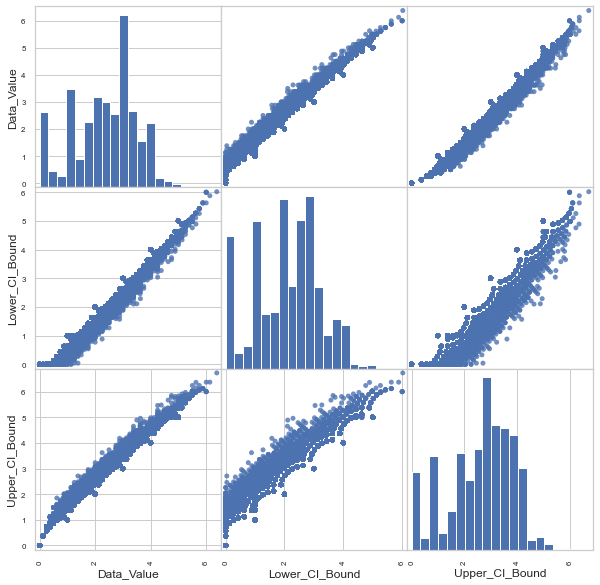

In [23]:
# We can also visualize all three of them together
sns.set(style="whitegrid", color_codes=True)
pd.plotting.scatter_matrix(abilities_df[['Data_Value','Lower_CI_Bound','Upper_CI_Bound']], 
                           figsize=(10,10), hist_kwds={'bins':20}, s=100, alpha = .8, cmap=mglearn.cm2)
plt.show()

Yes, not so pretty but we are just taking a look at our data. Because of this strong correlation, we will drop Lower_CI_Bound and Upper_CI_Bound. Data_Value gives us all the information we need.

In [54]:
# We can drop the features that we won't need for this analysis
merge_df = merge_df.filter(['O*NET-SOC_Code', 'Title', 'Element_Name', 'Data_Value'], axis=1)
merge_df.head()

,O*NET-SOC_Code,Title,Element_Name,Data_Value
1,11-1011.00,Chief Executives,Reading Comprehension,4.75
3,11-1011.00,Chief Executives,Active Listening,4.88
5,11-1011.00,Chief Executives,Writing,4.38
7,11-1011.00,Chief Executives,Speaking,4.88
9,11-1011.00,Chief Executives,Mathematics,3.62


In [55]:
# Lets check the number of missing values in our data.
merge_df.isnull().sum()

O*NET-SOC_Code    0
Title             0
Element_Name      0
Data_Value        0
dtype: int64

### Defining Analytical Work

After examining the ``Element_name`` column and going through each of them, the following elements stood out as good characteristics for analytical work.

 #### Necessary Abilities
 - $\color{blue}{\text{Problem Sensitivity}}$
     - The ability to tell when something is wrong or is likely to go wrong. It does not involve solving the problem, only recognizing there is a problem.
     
 - $\color{blue}{\text{Deductive Reasoning}}$
     - The ability to apply general rules to specific problems to produce answers that make sense.
 - $\color{blue}{\text{Inductive Reasoning}}$
     - The ability to combine pieces of information to form general rules or conclusions (includes finding a relationship among seemingly unrelated events).
 - $\color{blue}{\text{Mathematical Reasoning}}$
     - The ability to choose the right mathematical methods or formulas to solve a problem.
     

#### Necessary Skills
 - $\color{blue}{\text{Mathematics}}$
     - Using mathematics to solve problems.
 - $\color{blue}{\text{Science}}$
     - Using scientific rules and methods to solve problems.
 - $\color{blue}{\text{Critical Thinking}}$
     - Using logic and reasoning to identify the strengths and weaknesses of alternative solutions, conclusions or approaches to problems.
 - $\color{blue}{\text{Complex Problem Solving}}$
     - Identifying complex problems and reviewing related information to develop and evaluate options and implement solutions.
 - $\color{blue}{\text{Judgment and Decision Making}}$
     - Considering the relative costs and benefits of potential actions to choose the most appropriate one.


#### Necessary Knowledge
 - $\color{blue}{\text{Mathematics}}$
     - Knowledge of arithmetic, algebra, geometry, calculus, statistics, and their applications.

There are other characteristics that could be considered however, most of them are subjective. For example, under knowledge we have characteristics like `Design, Physics, and Chemistry`. As much as this knowledge is necessary for people in the mentioned fields, knowing chemistry is not necessary for someone doing financial analysis. Therefore, we will to drop such characteristics to minimize the bias. 

Furthermore, I examined about 100 occupations, both analytic occupations, none analytic and those in between, and determined that the occupations that I am absolutely sure that they are analytical in nature have a `Data value` $\approx$ 3.8 and above for each of the listed characteristics. Therefore, to minimize the bias I settled for $\approx$ 3.9 score. If, the `Data Value` is less than 3.9 I will discarded it.

Once this is done, I will group the occupation by `O*NET-SOC_Code` and instead of grouping each unique occupation by `mean` I will sum them up and I expect to get a summation of 1 if the characterist is present and zero if absent. That being said, I should also mention that since **Mathematics** is presence in both the Skills and Knowledge data we should expect a total of 2 for some of the summations for the Mathematics columns.

In [56]:
# Use get_dummies to get the features we need from the Element name column
# But first let us drop the first two column
temp_df = merge_df.filter(['Element_Name', 'Data_Value'], axis = 1)
print('Original featuer after preprocessing:\n {}'.format(list(temp_df.columns)))
merge_dummies = pd.get_dummies(temp_df)
print('Features after get_dummies:\n {}' .format(list(merge_dummies.columns)) )

Original featuer after preprocessing:
 ['Element_Name', 'Data_Value']
Features after get_dummies:
 ['Data_Value', 'Element_Name_Active Learning', 'Element_Name_Active Listening', 'Element_Name_Administration and Management', 'Element_Name_Arm-Hand Steadiness', 'Element_Name_Auditory Attention', 'Element_Name_Biology', 'Element_Name_Building and Construction', 'Element_Name_Category Flexibility', 'Element_Name_Chemistry', 'Element_Name_Clerical', 'Element_Name_Communications and Media', 'Element_Name_Complex Problem Solving', 'Element_Name_Computers and Electronics', 'Element_Name_Control Precision', 'Element_Name_Coordination', 'Element_Name_Critical Thinking', 'Element_Name_Customer and Personal Service', 'Element_Name_Deductive Reasoning', 'Element_Name_Depth Perception', 'Element_Name_Design', 'Element_Name_Dynamic Flexibility', 'Element_Name_Dynamic Strength', 'Element_Name_Economics and Accounting', 'Element_Name_Education and Training', 'Element_Name_Engineering and Technology', 

In [57]:
# just for fun let us check for shape
merge_dummies.shape

(102320, 120)

In [58]:
# now let us get characteristics we want.
vital_elements = merge_dummies.filter(['Data_Value','Element_Name_Critical Thinking', 'Element_Name_Deductive Reasoning', 
                                       'Element_Name_Inductive Reasoning', 'Element_Name_Judgment and Decision Making', 
                                       'Element_Name_Mathematical Reasoning', 'Element_Name_Mathematics', 
                                       'Element_Name_Science', 'Element_Name_Problem Sensitivity', 
                                       'Element_Name_Complex Problem Solving'], 
                                          axis = 1)
vital_elements.head()

,Data_Value,Element_Name_Critical Thinking,Element_Name_Deductive Reasoning,Element_Name_Inductive Reasoning,Element_Name_Judgment and Decision Making,Element_Name_Mathematical Reasoning,Element_Name_Mathematics,Element_Name_Science,Element_Name_Problem Sensitivity,Element_Name_Complex Problem Solving
1,4.75,0,0,0,0,0,0,0,0,0
3,4.88,0,0,0,0,0,0,0,0,0
5,4.38,0,0,0,0,0,0,0,0,0
7,4.88,0,0,0,0,0,0,0,0,0
9,3.62,0,0,0,0,0,1,0,0,0


In [59]:
# let us bring it all together
final_merged_df = pd.concat([merge_df.filter(['O*NET-SOC_Code','Title'], axis = 1), vital_elements], axis = 1)
final_merged_df.head()

,O*NET-SOC_Code,Title,Data_Value,Element_Name_Critical Thinking,Element_Name_Deductive Reasoning,Element_Name_Inductive Reasoning,Element_Name_Judgment and Decision Making,Element_Name_Mathematical Reasoning,Element_Name_Mathematics,Element_Name_Science,Element_Name_Problem Sensitivity,Element_Name_Complex Problem Solving
1,11-1011.00,Chief Executives,4.75,0,0,0,0,0,0,0,0,0
3,11-1011.00,Chief Executives,4.88,0,0,0,0,0,0,0,0,0
5,11-1011.00,Chief Executives,4.38,0,0,0,0,0,0,0,0,0
7,11-1011.00,Chief Executives,4.88,0,0,0,0,0,0,0,0,0
9,11-1011.00,Chief Executives,3.62,0,0,0,0,0,1,0,0,0


In [60]:
# These are the new features
print('Original featuer after preprocessing:\n {}'.format(list(final_merged_df)))

Original featuer after preprocessing:
 ['O*NET-SOC_Code', 'Title', 'Data_Value', 'Element_Name_Critical Thinking', 'Element_Name_Deductive Reasoning', 'Element_Name_Inductive Reasoning', 'Element_Name_Judgment and Decision Making', 'Element_Name_Mathematical Reasoning', 'Element_Name_Mathematics', 'Element_Name_Science', 'Element_Name_Problem Sensitivity', 'Element_Name_Complex Problem Solving']


In [61]:
final_merged_df.describe()

,Data_Value,Element_Name_Critical Thinking,Element_Name_Deductive Reasoning,Element_Name_Inductive Reasoning,Element_Name_Judgment and Decision Making,Element_Name_Mathematical Reasoning,Element_Name_Mathematics,Element_Name_Science,Element_Name_Problem Sensitivity,Element_Name_Complex Problem Solving
count,102320.000000,102320.000000,102320.000000,102320.000000,102320.000000,102320.000000,102320.000000,102320.000000,102320.000000,102320.000000
mean,2.204764,0.009451,0.009451,0.009441,0.009451,0.009451,0.015530,0.009138,0.009451,0.009431
std,1.360944,0.096755,0.096755,0.096705,0.096755,0.096755,0.123647,0.095156,0.096755,0.096656
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.380000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.920000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [62]:
# Now that we have the features we want we can drop all data values with values less than 3.9 since this is our score value
final_merged_df = final_merged_df[final_merged_df.Data_Value > 3.8]
final_merged_df.head()

,O*NET-SOC_Code,Title,Data_Value,Element_Name_Critical Thinking,Element_Name_Deductive Reasoning,Element_Name_Inductive Reasoning,Element_Name_Judgment and Decision Making,Element_Name_Mathematical Reasoning,Element_Name_Mathematics,Element_Name_Science,Element_Name_Problem Sensitivity,Element_Name_Complex Problem Solving
1,11-1011.00,Chief Executives,4.75,0,0,0,0,0,0,0,0,0
3,11-1011.00,Chief Executives,4.88,0,0,0,0,0,0,0,0,0
5,11-1011.00,Chief Executives,4.38,0,0,0,0,0,0,0,0,0
7,11-1011.00,Chief Executives,4.88,0,0,0,0,0,0,0,0,0
13,11-1011.00,Chief Executives,4.75,1,0,0,0,0,0,0,0,0


In [63]:
# groupby O*NET-SOC_Code and Title, by taking the sum, we can also use mean but for our purpose here sum() will do.
merged_data_grouped = final_merged_df.groupby(['O*NET-SOC_Code','Title']).sum()
merged_data_grouped.head()

,,Data_Value,Element_Name_Critical Thinking,Element_Name_Deductive Reasoning,Element_Name_Inductive Reasoning,Element_Name_Judgment and Decision Making,Element_Name_Mathematical Reasoning,Element_Name_Mathematics,Element_Name_Science,Element_Name_Problem Sensitivity,Element_Name_Complex Problem Solving
O*NET-SOC_Code,Title,,,,,,,,,,
11-1011.00,Chief Executives,221.40,1,1,1,1,1,1,0,1,1
11-1011.03,Chief Sustainability Officers,76.25,1,1,1,0,0,0,0,1,1
11-1021.00,General and Operations Managers,94.60,1,0,0,0,0,1,0,1,0
11-2011.00,Advertising and Promotions Managers,147.44,1,1,1,1,0,0,0,1,1
11-2021.00,Marketing Managers,135.21,1,1,1,1,0,1,0,1,1


In [64]:
merged_data_grouped.describe()

,Data_Value,Element_Name_Critical Thinking,Element_Name_Deductive Reasoning,Element_Name_Inductive Reasoning,Element_Name_Judgment and Decision Making,Element_Name_Mathematical Reasoning,Element_Name_Mathematics,Element_Name_Science,Element_Name_Problem Sensitivity,Element_Name_Complex Problem Solving
count,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000
mean,58.915880,0.477866,0.463110,0.399546,0.245176,0.104427,0.303065,0.091941,0.412032,0.208854
std,46.501259,0.499794,0.498921,0.490083,0.430436,0.305987,0.526655,0.289107,0.492480,0.406720
min,3.810000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,48.760000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,93.840000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,223.460000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000


As expected we have a max entry of 2 for the Mathematics column

### Labeling of occupations as “analytical” or "non-analytical"

Now that we have the data in the formate we want it, the next thing now will be to label the occupations as either analytical or non-analytical. 

This will be done by summing the columns values from ***Element Name_Critical Thinking*** to ***Element Name_Complex Problem Solving***. If the result is equal to 8 then we will classify that occupation as **analytical** and assign `1`, if it is less than 8 then we will assign it a value of `0`. The `score` of 8 is arrived at from the fact that if all the characteristics are present then we would get 9 in total after the summation, but we subtract 1 as a way of accounting for uncertainties and biases.

In [65]:
# get the columns we wish to sum over and put them in a list
listcol = merged_data_grouped.columns
listcol

Index(['Data_Value', 'Element_Name_Critical Thinking',
       'Element_Name_Deductive Reasoning', 'Element_Name_Inductive Reasoning',
       'Element_Name_Judgment and Decision Making',
       'Element_Name_Mathematical Reasoning', 'Element_Name_Mathematics',
       'Element_Name_Science', 'Element_Name_Problem Sensitivity',
       'Element_Name_Complex Problem Solving'],
      dtype='object')

In [66]:
# create a new list from the output
list_col = ['Element_Name_Critical Thinking', 'Element_Name_Deductive Reasoning', 'Element_Name_Inductive Reasoning',
            'Element_Name_Judgment and Decision Making','Element_Name_Mathematical Reasoning', 'Element_Name_Mathematics',
            'Element_Name_Science', 'Element_Name_Problem Sensitivity','Element_Name_Complex Problem Solving']


# create a new column called "Occ_estimator" which contains the summation of each row from the features in the list_col
merged_data_grouped['Occ_estimator'] = merged_data_grouped.loc[:,list_col].sum(axis=1)
merged_data_grouped.head()

,,Data_Value,Element_Name_Critical Thinking,Element_Name_Deductive Reasoning,Element_Name_Inductive Reasoning,Element_Name_Judgment and Decision Making,Element_Name_Mathematical Reasoning,Element_Name_Mathematics,Element_Name_Science,Element_Name_Problem Sensitivity,Element_Name_Complex Problem Solving,Occ_estimator
O*NET-SOC_Code,Title,,,,,,,,,,,
11-1011.00,Chief Executives,221.40,1,1,1,1,1,1,0,1,1,8
11-1011.03,Chief Sustainability Officers,76.25,1,1,1,0,0,0,0,1,1,5
11-1021.00,General and Operations Managers,94.60,1,0,0,0,0,1,0,1,0,3
11-2011.00,Advertising and Promotions Managers,147.44,1,1,1,1,0,0,0,1,1,6
11-2021.00,Marketing Managers,135.21,1,1,1,1,0,1,0,1,1,7


The main objective here is to label only a subset of the data and then make prediction later on. However, I will go ahead and label everything for the purpose of accuracy measurement once we get the predicted values. 

So, even though I am labeling everything here, I will only use a portion of the data on training and the rest will be predicted values which I will use for to answer the question of `gender gap` in analytical workforce.

In [67]:
# Create a Target Column
merged_data_grouped['Target'] = ""

# Add data to it
# if the value in "Occ_estimator" is less than 8 set value in "Target" equal to zero (0) 
merged_data_grouped.loc[merged_data_grouped['Occ_estimator'] < 8, ['Target']] = 0
# if the value in "Occ_estimator" is greater than 8 set value in "Target" equal to one (1)
merged_data_grouped.loc[merged_data_grouped['Occ_estimator'] > 7, ['Target']] = 1
merged_data_grouped.head()

,,Data_Value,Element_Name_Critical Thinking,Element_Name_Deductive Reasoning,Element_Name_Inductive Reasoning,Element_Name_Judgment and Decision Making,Element_Name_Mathematical Reasoning,Element_Name_Mathematics,Element_Name_Science,Element_Name_Problem Sensitivity,Element_Name_Complex Problem Solving,Occ_estimator,Target
O*NET-SOC_Code,Title,,,,,,,,,,,,
11-1011.00,Chief Executives,221.40,1,1,1,1,1,1,0,1,1,8,1
11-1011.03,Chief Sustainability Officers,76.25,1,1,1,0,0,0,0,1,1,5,0
11-1021.00,General and Operations Managers,94.60,1,0,0,0,0,1,0,1,0,3,0
11-2011.00,Advertising and Promotions Managers,147.44,1,1,1,1,0,0,0,1,1,6,0
11-2021.00,Marketing Managers,135.21,1,1,1,1,0,1,0,1,1,7,0


In [68]:
# how many classified as analytical?
print('There are ' + str(merged_data_grouped.Target.sum()) + " occupations classified as analytical.")

There are 74 occupations classified as analytical.


In [69]:
#merged_data_grouped.to_excel('merged_output_final.xlsx')
merged_data_grouped = pd.read_excel('merged_output_final.xlsx')
merged_data_grouped.shape

(881, 14)

In [70]:
# check the variance of the data
print(merged_data_grouped.var())

Data_Value                                   2162.367091
Element_Name_Critical Thinking                  0.249794
Element_Name_Deductive Reasoning                0.248922
Element_Name_Inductive Reasoning                0.240182
Element_Name_Judgment and Decision Making       0.185275
Element_Name_Mathematical Reasoning             0.093628
Element_Name_Mathematics                        0.277366
Element_Name_Science                            0.083583
Element_Name_Problem Sensitivity                0.242537
Element_Name_Complex Problem Solving            0.165422
Occ_estimator                                   8.566884
Target                                          0.077028
dtype: float64


In [71]:
merged_data_grouped.cov()

,Data_Value,Element_Name_Critical Thinking,Element_Name_Deductive Reasoning,Element_Name_Inductive Reasoning,Element_Name_Judgment and Decision Making,Element_Name_Mathematical Reasoning,Element_Name_Mathematics,Element_Name_Science,Element_Name_Problem Sensitivity,Element_Name_Complex Problem Solving,Occ_estimator,Target
Data_Value,2162.367091,18.314005,18.480581,17.109319,14.524125,5.546158,11.576568,6.072913,15.185859,12.581316,119.390844,5.959881
Element_Name_Critical Thinking,18.314005,0.249794,0.203444,0.182717,0.128160,0.050041,0.085693,0.048060,0.152880,0.108037,1.208826,0.043907
Element_Name_Deductive Reasoning,18.480581,0.203444,0.248922,0.196574,0.130646,0.053857,0.092443,0.048282,0.168058,0.112259,1.254484,0.045148
Element_Name_Inductive Reasoning,17.109319,0.182717,0.196574,0.240182,0.136021,0.053684,0.071956,0.052996,0.171551,0.123277,1.228957,0.050493
Element_Name_Judgment and Decision Making,14.524125,0.128160,0.130646,0.136021,0.185275,0.051641,0.073339,0.051296,0.113638,0.121463,0.991478,0.058928
Element_Name_Mathematical Reasoning,5.546158,0.050041,0.053857,0.053684,0.051641,0.093628,0.091043,0.035843,0.041015,0.054302,0.525053,0.062810
Element_Name_Mathematics,11.576568,0.085693,0.092443,0.071956,0.073339,0.091043,0.277366,0.048241,0.059077,0.072996,0.872152,0.076788
Element_Name_Science,6.072913,0.048060,0.048282,0.052996,0.051296,0.035843,0.048241,0.083583,0.046165,0.056912,0.471378,0.045678
Element_Name_Problem Sensitivity,15.185859,0.152880,0.168058,0.171551,0.113638,0.041015,0.059077,0.046165,0.242537,0.102484,1.097405,0.044897
Element_Name_Complex Problem Solving,12.581316,0.108037,0.112259,0.123277,0.121463,0.054302,0.072996,0.056912,0.102484,0.165422,0.917151,0.065392


One thing that is of interest is figuring out which of the characteristics is the most common one among workers in analytical work. Now, there are many ways to do this but we are going to go with the easiest one where we plot each characteristic against the Target.

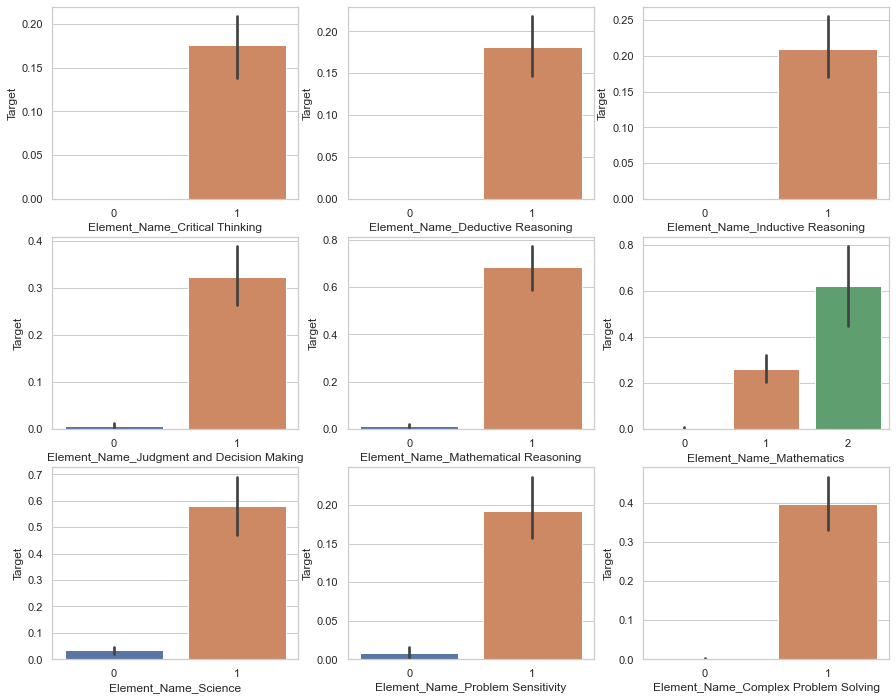

In [72]:
# seaborn to make it prettier
sns.set(style="whitegrid", color_codes=True)
# create a 3 by 3 subplot for all the 9 characteristics features
fig, ax1 = plt.subplots(3, 3, figsize=(15, 12))
# initialize m to 0
m = 0
# use this to set the location for each subplot
for i,j in enumerate(ax1):
    for k in range(len(j)):
        ax = sns.barplot(x=list_col[(m)], y="Target", data=merged_data_grouped, ax=ax1[i,k])
        m = m + 1 

We can see that one of the top qualities to have for analytical work is **Mathematical Reasoning** seconded by **Mathematics** according to this simple analysis. I hope to check if there will be any major changes once we make the final prediction.


Text(0, 0.5, 'Element Name_Mathematical Reasoning')

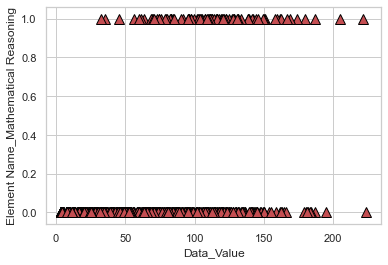

In [73]:
# Here I am just displaying the general behaviour of what the plot of "Data_Value against elements of "analytical work" 
# in this particular example it is against "Element Name_Mathematical Reasoning". The data is distributed among 0 and 1

mglearn.discrete_scatter(merged_data_grouped['Data_Value'], merged_data_grouped['Element_Name_Mathematical Reasoning'], 
                         c= 'red', markers='^')
plt.xlabel('Data_Value')
plt.ylabel('Element Name_Mathematical Reasoning')

In [74]:
# reset the index
merged_data_grouped = merged_data_grouped.reset_index(drop=True)

In [75]:
# let us check for duplicates
merged_data_grouped.duplicated().sum()

0

### Great!!!!!!

The data is ready for some predictions!!!

### Prediction

Here we shall try out a few models before setting on one. This will allow for us to get a sense of what accuracy range we should be expecting.

For this reason let us make use of the `sklearn.pipeline` object. This will allow us to to collect preprocessing steps and the model into one object which can be trained. The primary advantage is that one can avoid having to do fit/transform preprocessing steps like MinMaxScaler() etc on each dataset. You can have many pipelines to train for each model type you would like to test out.

#### Pipeline Construction

In [76]:
# import the pipeline object and the model to try out.
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

Great! We have the basics that we need for us to run some models. 
To do that I will write a function that takes in a model and prints out the accuracy on Train, Dev and test data.

In [77]:
# a bit more preprocessing of the data before we get started
# splite the data into Train and test set 383 each or there about
train, test = train_test_split(merged_data_grouped, test_size=0.5, random_state=4)
# split train into train_d and dev sets
train_d, dev = train_test_split(train, test_size=0.21, random_state=4)
# define dev set.   
X_dev = dev.filter(['Data_Value', 'Element_Name_Critical Thinking','Element_Name_Deductive Reasoning', 
                    'Element_Name_Inductive Reasoning','Element_Name_Judgment and Decision Making',
                    'Element_Name_Mathematical Reasoning', 'Element_Name_Mathematics','Element_Name_Science', 
                    'Element_Name_Problem Sensitivity','Element_Name_Complex Problem Solving'], axis=1)
y_dev = dev['Target'].values
# define train_d sets
X_train_d = train_d.filter(['Data_Value', 'Element_Name_Critical Thinking','Element_Name_Deductive Reasoning', 
                            'Element_Name_Inductive Reasoning','Element_Name_Judgment and Decision Making',
                            'Element_Name_Mathematical Reasoning', 'Element_Name_Mathematics','Element_Name_Science', 
                            'Element_Name_Problem Sensitivity','Element_Name_Complex Problem Solving'], axis=1)
y_train_d = train_d["Target"]

# Here are defining X_data
X_train = train.filter(['Data_Value', 'Element_Name_Critical Thinking','Element_Name_Deductive Reasoning', 
                        'Element_Name_Inductive Reasoning','Element_Name_Judgment and Decision Making',
                        'Element_Name_Mathematical Reasoning', 'Element_Name_Mathematics','Element_Name_Science', 
                        'Element_Name_Problem Sensitivity','Element_Name_Complex Problem Solving'], axis=1)

X_test = test.filter(['Data_Value', 'Element_Name_Critical Thinking','Element_Name_Deductive Reasoning', 
                        'Element_Name_Inductive Reasoning','Element_Name_Judgment and Decision Making',
                        'Element_Name_Mathematical Reasoning', 'Element_Name_Mathematics','Element_Name_Science', 
                        'Element_Name_Problem Sensitivity','Element_Name_Complex Problem Solving'], axis=1)

# Here are defining y_data
y_train = train['Target'].values
y_test = test['Target'].values

In [78]:
print('Train set size: {}'.format(train.shape) + "\nNumber of predicted values: {}".format(train.Target.sum()))

Train set size: (440, 14)
Number of predicted values: 34


In [79]:
print('Test set size: {}'.format(test.shape) + "\nNumber of predicted values: {}".format(test.Target.sum()))

Test set size: (441, 14)
Number of predicted values: 40


In [80]:
cols = ['Data_Value', 'Element_Name_Critical Thinking','Element_Name_Deductive Reasoning', 
                        'Element_Name_Inductive Reasoning','Element_Name_Judgment and Decision Making',
                        'Element_Name_Mathematical Reasoning', 'Element_Name_Mathematics','Element_Name_Science', 
                        'Element_Name_Problem Sensitivity','Element_Name_Complex Problem Solving', 'Target']
df_ = pd.DataFrame(merged_data_grouped[cols].iloc[:,range(0,11)].values, columns= cols)
stdsc = StandardScaler()
X_std = stdsc.fit_transform(df_)
cov_mat = np.cov(X_std.T)

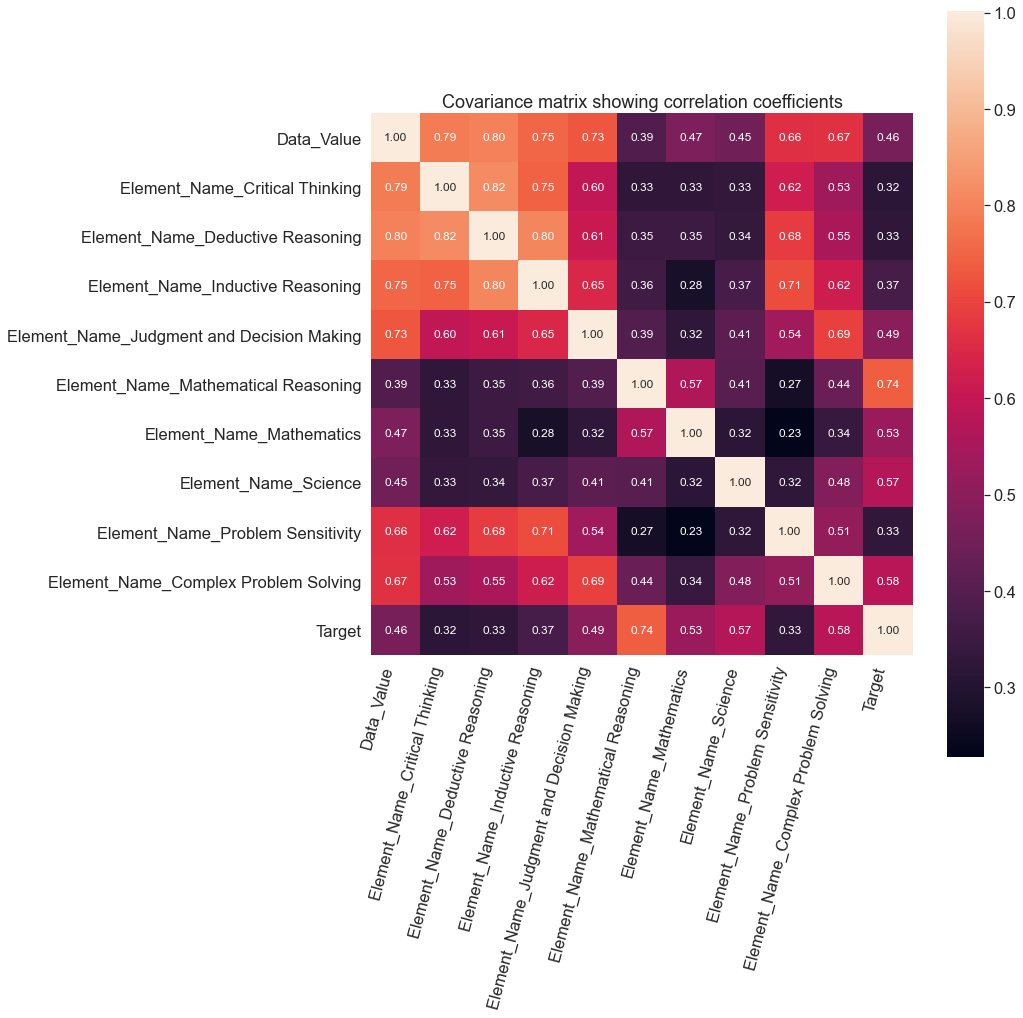

In [81]:
plt.figure(figsize=(15,15))
sns.set(font_scale=1.5)
hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12},
                 yticklabels=cols,
                 xticklabels=cols)
plt.title('Covariance matrix showing correlation coefficients')
plt.tight_layout()
hm.set_xticklabels(hm.get_xticklabels(), rotation=75, horizontalalignment='right')
plt.show()

In [82]:
def make_model(steps):
    """ 
    input:
    step = List of (name, transform) tuples (implementing fit/transform) that are chained, 
           in the order in which they are chained, with the last object an estimator.
    
    prints:
    Train set accuracy: is this the accuracy score on train data
    Dev set accuracy: is this the accuracy score on dev data
    Jaccard index: is used to compare set of predicted labels for a sample to the corresponding set of labels in y_true
    F1-score: is a measure of a test's accuracy
    
    Returns:
    An array containing the predicted values.
    """
    
    #initialize the Pipeline object
    pipe = Pipeline(steps)
    
    # fit the data
    pipe.fit(X_train_d, y_train_d)
    
    # make some prediction and save them in an array yhat
    dev_yhat = pipe.predict(X_dev)
    
    # print scores on the and dev sets
    print('Train set accuracy: {:.2f}'.format(pipe.score(X_train_d, y_train_d)))
    print('Dev set accuracy: {:.2f}'.format(pipe.score(X_dev, y_dev)))
    
    # make predictions on test set
    test_yhat = pipe.predict(X_test)
    
    # the scores on test set
    print("Jaccard index: %.2f" % jaccard_score(y_test, test_yhat, average='weighted'))
    print("F1-score: %.2f" % f1_score(y_test, test_yhat, average='weighted'))
    
    return test_yhat

In [83]:
# Let try our model on a K_Nearest Neighbor_classifier
# And see its performance 
yhat_KNN = make_model([('scaler', StandardScaler()), ('neighbors', KNeighborsClassifier(n_neighbors=2))])

Train set accuracy: 0.99
Dev set accuracy: 1.00
Jaccard index: 0.96
F1-score: 0.98


In [84]:
# Let try our model on a Decision_Tree_Classifier
# And see its performance 
yhat_DT = make_model([('scaler', StandardScaler()), ('tree', DecisionTreeClassifier(criterion="entropy", max_depth = 2))])

Train set accuracy: 0.98
Dev set accuracy: 1.00
Jaccard index: 0.95
F1-score: 0.97


In [85]:
# Let try our model on a Support Vector Classifier
# And see its performance 
yhat_SVM = make_model([('scaler', StandardScaler()), ('svc', SVC())])

Train set accuracy: 0.99
Dev set accuracy: 1.00
Jaccard index: 0.96
F1-score: 0.98


For the regression model we can also print out the loss/cost of the regression, but I will skip this part for now.

In [86]:
# Let try our model on a LogisticRegression
# And see its performance 
yhat_LR = make_model([('scaler', StandardScaler()), ('linear_model', LogisticRegression(C=0.05))])

Train set accuracy: 0.99
Dev set accuracy: 1.00
Jaccard index: 0.96
F1-score: 0.98


In [87]:
# Let try our model on a LogisticRegression
# And see its performance 
yhat_RFC = make_model([('scaler', StandardScaler()), ('ensemble', RandomForestClassifier(max_depth=4,n_estimators=10))])

Train set accuracy: 0.99
Dev set accuracy: 1.00
Jaccard index: 0.96
F1-score: 0.98


The scores look very good however, I am not sure if at this point a looking at a classic example of overfitting or not. One thing we can do, which we sort of did informally, is to find out the contributions of each feature in the data set.

### Imbalanced Datasets
One problem to consider is that our data is highly imbalanced. That is, one class (specifically, non-analytic occupation) is much more frequent than the other data.

Therefore, using a tree based classifier I will use the SHAP package for shap value analysis. Shap values explain the contributions that individual features make towards a prediction.

In [92]:
# import the module
#!pip install shap
import shap

[0.08957416 0.         0.         0.01012244 0.06843674 0.35704473
 0.15354223 0.14014485 0.00050286 0.18063198]


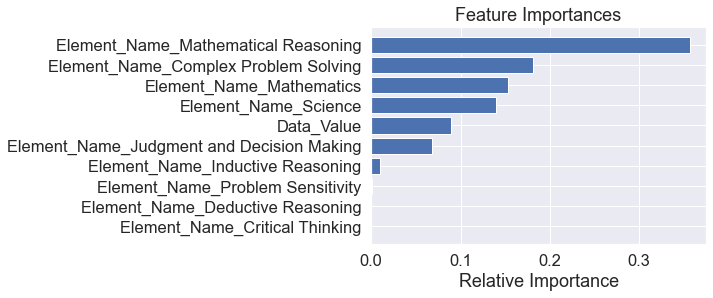

In [93]:
# Initialize a RandomForestClassifier object and fit it to the training set
model = RandomForestClassifier(max_depth=6, random_state=0, n_estimators=10).fit(X_train, y_train)

# get the feature_importances values
# Variables are ranked in descending order
print(model.feature_importances_)

importances = model.feature_importances_
indices = np.argsort(importances)

# plot the results here
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

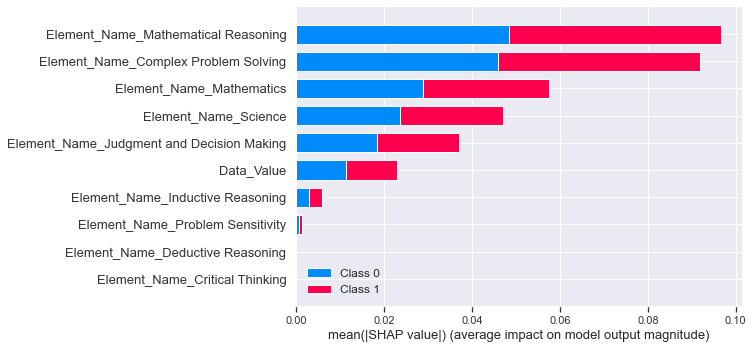

In [94]:
# get the SHAP values from the trained model
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

From the plot above we can see that the ***"Element Name_Complex Problem Solving"*** have a hight positive contribution to the target variable. In the first graph we have feature importances where it agree with the second graph that ***"Element Name_Complex Problem Solving"*** has the highest contribution. This is what we would generally expect from someone with in an analytical work i.e. they would have to have the ability to solve problems. 

We also see that **Critical Thinking** and Deductive Reasoning are not all that useful in this prediction. This comes as a surprise as one would expect that critical thinking is essential for someone in analytical work. I suspect that this was due to the fact that these two are not that common in our dataset.

With this information we are settled that our features are good enough for predictions purposes. There is one thing that we can do at this point to help us with model selection. That is the use of **Cross Validation**.


### Model Selection.

We will go back and make some modification to the our make_model functions such that it incorporates **cross validation**.
We will use the `Shuffle-split corss-validation`.

In [95]:
# import the necessary modules
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

In [96]:
def make_model_cross_val(steps):

    """ 
    input:
    step = List of (name, transform) tuples (implementing fit/transform) that are chained, 
           in the order in which they are chained, with the last object an estimator.
    
    prints:
    Train set accuracy: is this the accuracy score on train data
    Jaccard index: is used to compare set of predicted labels for a sample to the corresponding set of labels in y_true
    F1-score: is a measure of a test's accuracy
    Average cross-validation score
    
    Returns:
    An array containing the predicted values.
    """    

    # splite the data into Train and test set 383 each or there about
    shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)

    # preprocessing for cross_validation purposes
    # here I will split the data into train and test only by 50%
    X_df = merged_data_grouped.drop(['O*NET-SOC_Code','Title',"Target"], axis=1)
    y_df = merged_data_grouped['Target'].values
    
    #initialize the Pipeline object
    pipe = Pipeline(steps)
    
    # fit the data
    pipe.fit(X_train, y_train)
    
    # print accuracy on test set
    print('Train set accuracy: {:.2f}'.format(pipe.score(X_train, y_train)))
   
    # make some prediction and save them in an array yhat
    test_yhat = pd.DataFrame(pipe.predict(X_test))
    
    # print Jaccard and F1 scores
    print("Jaccard index: %.2f" % jaccard_score(y_test, test_yhat, average='weighted'))
    print("F1-score: %.2f" % f1_score(y_test, test_yhat, average='weighted'))
    
    # print the average cross-validation scores
    scores = cross_val_score(pipe, X_df, y_df, cv=shuffle_split)
    print("Average cross-validation score: {:.2f}".format(scores.mean()))
    
    # An array containing the predicted values.   
    return test_yhat

In [97]:
# Let try our model on a K_Nearest Neighbor_classifier
# And see its performance 
yhat_KNN = make_model_cross_val([('scaler', StandardScaler()), ('neighbors', KNeighborsClassifier(n_neighbors=2))])

Train set accuracy: 0.99
Jaccard index: 0.96
F1-score: 0.98
Average cross-validation score: 0.99


In [98]:
#yhat_KNN.sum()

In [99]:
# Let try our model on a Decision_Tree_Classifier
# And see its performance 
yhat_DT = make_model_cross_val([('scaler', StandardScaler()), ('tree', DecisionTreeClassifier(criterion="entropy", max_depth = 2))])

Train set accuracy: 0.99
Jaccard index: 0.95
F1-score: 0.97
Average cross-validation score: 1.00


In [100]:
# yhat_DT.sum()

In [101]:
# Let try our model on a Support Vector Classifier
# And see its performance 
yhat_SVM = make_model_cross_val([('scaler', StandardScaler()), ('svc', SVC(random_state=4, C=10))])

Train set accuracy: 1.00
Jaccard index: 0.99
F1-score: 0.99
Average cross-validation score: 0.99


In [102]:
#yhat_SVM.sum()

In [103]:
# Let try our model on a LogisticRegression
# And see its performance 
yhat_LR = make_model_cross_val([('scaler', StandardScaler()), ('linear_model', LogisticRegression(random_state=4,C=0.5))])

Train set accuracy: 1.00
Jaccard index: 0.99
F1-score: 0.99
Average cross-validation score: 1.00


In [104]:
#yhat_LR.sum()

In [105]:
# Let try our model on a RandomForestClassifier
# And see its performance 
yhat_RFC = make_model_cross_val([('scaler', StandardScaler()), ('ensemble', RandomForestClassifier(max_depth=4,n_estimators=10))])

Train set accuracy: 1.00
Jaccard index: 0.97
F1-score: 0.99
Average cross-validation score: 1.00


In [106]:
# yhat_RFC.sum()

#### Brief Report
From face value, it seems like all the models are doing well, I have assembled a table below of the F1-score Jaccard_score and Cross-Validation.

| Algorithm          | F1-score | Jaccard | Cross-Val |
|--------------------|----------|---------|-----------|
| KNN                |   0.98   |  0.96   |   0.99    |
| Decision Tree      |   0.97   |  0.95   |   1.00    |
| SVM                |   0.99   |  0.99   |   0.99    |
| LogisticRegression |   0.99   |  0.99   |   1.00    |
| RandomForrest      |   0.99   |  0.97   |   1.00    |

From the above table, we will have to settle with the **Logistic Regression** model. Even though SVM and LR did well, I am very skepitical about their results, (1) given that SVM did extremely well on training set. That's usually a good indication of overfitting.

Remember that we use paramter C as our regularization parameter. Parameter C = 1/λ.

Lambda (λ) controls the trade-off between allowing the model to increase it's complexity as much as it wants with trying to keep it simple. For example, if λ is very low or 0, the model will have enough power to increase it's complexity (overfit) by assigning big values to the weights for each parameter. If, in the other hand, we increase the value of λ, the model will tend to underfit, as the model will become too simple.

Parameter C will work the other way around. For small values of C, we increase the regularization strength which will create simple models which underfit the data. For big values of C, we low the power of regularization which implies the model is allowed to increase it's complexity, and therefore, overfit the data.

Therefore, LR has a lower C, meaning we would expect it to underfit, yet it still performed better on with a really high F1-score.


Let us rebuilt our test set so that we can append it to our training set to get back what we had.

In [107]:
X_test = test.filter(['Data_Value', 'Element_Name_Critical Thinking','Element_Name_Deductive Reasoning', 
                        'Element_Name_Inductive Reasoning','Element_Name_Judgment and Decision Making',
                        'Element_Name_Mathematical Reasoning', 'Element_Name_Mathematics','Element_Name_Science', 
                        'Element_Name_Problem Sensitivity','Element_Name_Complex Problem Solving'], axis=1)

In [108]:
# Let use get the predicted occupation from our LR model and add them back to the testset X_test
X_test["Target"] = yhat_LR.values

In [109]:
# Insert the "O*NET-SOC_Code", "Title", and "Occ_estimator" column to X_test
# Now we have a full fill with occupations fully predicted by the our model
X_test.insert(0, "Title", test['Title'])
X_test.insert(0, 'O*NET-SOC_Code', test['O*NET-SOC_Code'])
X_test.insert(11, 'Occ_estimator', test['Occ_estimator'])
X_test.head()

,O*NET-SOC_Code,Title,Data_Value,Element_Name_Critical Thinking,Element_Name_Deductive Reasoning,Element_Name_Inductive Reasoning,Element_Name_Judgment and Decision Making,Element_Name_Mathematical Reasoning,Element_Name_Mathematics,Element_Name_Science,Element_Name_Problem Sensitivity,Occ_estimator,Element_Name_Complex Problem Solving,Target
127,15-1199.09,Information Technology Project Managers,88.52,1,1,1,0,0,0,0,1,5,1,0
157,17-2112.00,Industrial Engineers,94.36,1,1,1,0,0,1,0,1,6,1,0
668,47-2111.00,Electricians,46.72,0,1,0,0,0,1,0,0,2,0,0
286,23-2011.00,Paralegals and Legal Assistants,50.71,0,0,0,0,0,0,0,0,0,0,0
220,19-1032.00,Foresters,115.88,1,1,1,1,0,1,0,1,7,1,0


In [110]:
# we are ready to merge our training data with X_test
pred_occupations = train.append(X_test, sort=False)

In [111]:
# If everything works we should have shape of (847, 14) like we started
pred_occupations.shape

(881, 14)

In [112]:
pred_occupations.head()

,O*NET-SOC_Code,Title,Data_Value,Element_Name_Critical Thinking,Element_Name_Deductive Reasoning,Element_Name_Inductive Reasoning,Element_Name_Judgment and Decision Making,Element_Name_Mathematical Reasoning,Element_Name_Mathematics,Element_Name_Science,Element_Name_Problem Sensitivity,Element_Name_Complex Problem Solving,Occ_estimator,Target
846,53-3032.00,Heavy and Tractor-Trailer Truck Drivers,20.05,0,0,0,0,0,0,0,0,0,0,0
277,21-1093.00,Social and Human Service Assistants,70.85,0,1,0,0,0,0,0,1,0,2,0
389,27-4014.00,Sound Engineering Technicians,7.88,0,0,0,0,0,0,0,0,0,0,0
103,13-2099.02,Risk Management Specialists,83.04,1,1,1,1,1,1,0,1,1,8,1
196,17-3029.03,Electromechanical Engineering Technologists,60.01,1,0,0,0,0,1,0,1,0,3,0


We can also check for the total number of "analytical occupation" in our data set.

In [113]:
# The sum of the Target column
print('There are ' + str(pred_occupations.Target.sum()) + " occupations classified as analytical.")

There are 73 occupations classified as analytical.


A total of 73 occupations were classified as analytical, that about 8$\%$ of the total number of occupations in the dataset.

In [114]:
pred_occupations.isnull().sum()

O*NET-SOC_Code                               0
Title                                        0
Data_Value                                   0
Element_Name_Critical Thinking               0
Element_Name_Deductive Reasoning             0
Element_Name_Inductive Reasoning             0
Element_Name_Judgment and Decision Making    0
Element_Name_Mathematical Reasoning          0
Element_Name_Mathematics                     0
Element_Name_Science                         0
Element_Name_Problem Sensitivity             0
Element_Name_Complex Problem Solving         0
Occ_estimator                                0
Target                                       0
dtype: int64

In [115]:
#Let us make sure there are no duplicates
pred_occupations.duplicated().sum()

0

### Great!

We are ready to answer the question of gender gap in analytical work. Since are only interested in answering whether there is a gender gap in analytical work or not, the only occupations that will matter for the rest of the analysis are those predicted to be analytical. Therefore, we will go ahead and drop all non-analytical occupations.

But first let's get the other files

### Import more data

The first file, which we will call `occ_Gender_dist`, contains occupations titles and the percentage $\%$ of women in each occupation.

In [116]:
occ_Gender_dist = pd.read_excel('Occ_Gender_Distribution.xlsx')

The second file contains all the occupations titles and the total number of employees in each occupation.

In [117]:
occ_Employment = pd.read_excel('Occ_Employment.xlsx')

### Preprocessing

In [118]:
# Let us look at the data
occ_Gender_dist.head(10)

,SOC,SOCName,% Female (ACS)
0,13-2011,Accountants and Auditors,62.464481
1,27-2011,Actors,43.756546
2,15-2011,Actuaries,33.240230
3,51-9191,Adhesive Bonding Machine Operators and Tenders,41.962455
4,23-1021,"Administrative Law Judges, Adjudicators, and H...",39.736051
5,11-3011,Administrative Services Managers,39.864960
6,25-3011,Adult Basic and Secondary Education and Litera...,61.371962
7,11-2011,Advertising and Promotions Managers,57.811548
8,41-3011,Advertising Sales Agents,51.348100
9,17-3021,Aerospace Engineering and Operations Technicians,18.144636


In [119]:
occ_Gender_dist.describe()

,% Female (ACS)
count,808.000000
mean,38.449321
std,27.325574
min,0.613948
25%,12.585661
50%,38.189026
75%,58.603410
max,97.595722


In [120]:
occ_Employment.head()

,OCC_CODE,OCC_TITLE,OCC_GROUP,TOT_EMP
0,00-0000,All Occupations,total,144733270
1,11-0000,Management Occupations,major,7616650
2,11-1000,Top Executives,minor,2535640
3,11-1010,Chief Executives,broad,195530
4,11-1011,Chief Executives,detailed,195530


The first row of the `occ_Employment` dataset and column `TOT_EMP` gives us the total number of all employees in all the occupations. Let's verify that.

In [121]:
occ_Employment.TOT_EMP.sum()

723660370

### Whoa!

That's more than we expected. Well, we have to subtract the `144733270` from this total, but still!  Okay let us explore further.

In [122]:
# Let us view the first 20 rows
occ_Employment.head(20)

,OCC_CODE,OCC_TITLE,OCC_GROUP,TOT_EMP
0,00-0000,All Occupations,total,144733270
1,11-0000,Management Occupations,major,7616650
2,11-1000,Top Executives,minor,2535640
3,11-1010,Chief Executives,broad,195530
4,11-1011,Chief Executives,detailed,195530
5,11-1020,General and Operations Managers,broad,2289770
6,11-1021,General and Operations Managers,detailed,2289770
7,11-1030,Legislators,broad,50330
8,11-1031,Legislators,detailed,50330
9,11-2000,"Advertising, Marketing, Promotions, Public Rel...",minor,717220


#### That solves our mystery! Some of the data are repeated.

This is because the SOC taxonomy is hierarchical. The top-most level are “major” occupation groups. Minor occupation groups are nested inside major occupation groups, broad groups are nested inside minor occupation groups, and detailed occupation groups are nested inside broad occupation groups. The structure is: Detailed (most granular) $\rightarrow$ Broad $\rightarrow$  Minor $\rightarrow$  Major (least granular).

In [123]:
# Let's try to create a df with `OCC_GROUP` equal to detailed.
occ_Employment = occ_Employment[occ_Employment.OCC_GROUP == "detailed"]

In [124]:
occ_Employment.head(10)

,OCC_CODE,OCC_TITLE,OCC_GROUP,TOT_EMP
4,11-1011,Chief Executives,detailed,195530
6,11-1021,General and Operations Managers,detailed,2289770
8,11-1031,Legislators,detailed,50330
11,11-2011,Advertising and Promotions Managers,detailed,25260
13,11-2021,Marketing Managers,detailed,240440
14,11-2022,Sales Managers,detailed,379050
16,11-2031,Public Relations and Fundraising Managers,detailed,72460
19,11-3011,Administrative Services Managers,detailed,283570
21,11-3021,Computer and Information Systems Managers,detailed,391430
23,11-3031,Financial Managers,detailed,608120


In [125]:
# Let check for the total now. Remember we are aiming for 144733270
occ_Employment.TOT_EMP.sum()

144731220

#### Great! I am satisfied!

Time to start combining our datasets. It seems like we can combine `occ_Employment` and `occ_Gender_dist` on two fronts; ***OCC_CODE*** and ***OCC_TITLE***.

In [126]:
# check the shapes of the two files
print('occ_Employment shape: {}'.format(occ_Employment.shape) + '\nocc_Gender_dist shape: {}'.format(occ_Gender_dist.shape))

occ_Employment shape: (808, 4)
occ_Gender_dist shape: (808, 3)


### This is great! They the same number of rows

In [127]:
# But we need to make identical name colums to match OCC_CODE and OCC_TITLE
occ_Gender_dist = occ_Gender_dist.rename(columns={"SOC" : "OCC_CODE", "SOCName":"OCC_TITLE"})
occ_Gender_dist.head()

,OCC_CODE,OCC_TITLE,% Female (ACS)
0,13-2011,Accountants and Auditors,62.464481
1,27-2011,Actors,43.756546
2,15-2011,Actuaries,33.240230
3,51-9191,Adhesive Bonding Machine Operators and Tenders,41.962455
4,23-1021,"Administrative Law Judges, Adjudicators, and H...",39.736051


In [128]:
# lets mrege them
merged_occ_df = pd.merge(occ_Employment, occ_Gender_dist, on=['OCC_CODE', 'OCC_TITLE'])
merged_occ_df.head()

,OCC_CODE,OCC_TITLE,OCC_GROUP,TOT_EMP,% Female (ACS)
0,11-1011,Chief Executives,detailed,195530,25.330696
1,11-1021,General and Operations Managers,detailed,2289770,29.421290
2,11-1031,Legislators,detailed,50330,25.330696
3,11-2011,Advertising and Promotions Managers,detailed,25260,57.811548
4,11-2021,Marketing Managers,detailed,240440,45.821921


In [129]:
# let us pick out the files that we need
merged_occ_df = merged_occ_df.filter(['OCC_CODE','OCC_TITLE','TOT_EMP','% Female (ACS)'], axis=1)

In [130]:
# pick out the necessary columns from pred_occupations
pred_occupations = pred_occupations.filter(['O*NET-SOC_Code', 'Title', 'Target'], axis =1)
pred_occupations.head()

,O*NET-SOC_Code,Title,Target
846,53-3032.00,Heavy and Tractor-Trailer Truck Drivers,0
277,21-1093.00,Social and Human Service Assistants,0
389,27-4014.00,Sound Engineering Technicians,0
103,13-2099.02,Risk Management Specialists,1
196,17-3029.03,Electromechanical Engineering Technologists,0


In [131]:
# We are only interested in the ones that are classifie as one
pred_occupations = pred_occupations[pred_occupations.Target == 1].reset_index(drop=True)

Our next goal is to merge this set with the `merged_occ_df` and we will merge on `O*NET-SOC_Code`. However, we need to note that the O$^*$NET data is aggregated at an 8-digit level (e.g., 11-1011.03) whereas the `OCC_CODE` is at a 6-digit level (e.g., 11-1011). We need to make these match.

I am sure there are other ways to do this. But the easiest way I found was by looking closely at the data codes. The table below illustrates the conditions on I will match the two codes.

| O$*$NET-SOC Code   |       Title        |
|--------------------|--------------------|
|    11-1011.00      |   Chief Executives | 
|    27-2011.00      |   Actors           |

#### Compared to 

|      OCC_Code   |      Title        |
|-----------------|-------------------|
|    11-1011      |  Chief Executives | 
|    27-2011      |  Actors           |

The only difference in all the cases are just the last two digits after the decimal place. Well, it turns out that the `OCC_Code` and occupation list is identical to the one found [here](https://www.onetcenter.org/taxonomy/2019/soc_without.html). I have noticed that all the predicted values in with a coresponding `O*NET-SOC_Code` not ending in ".00" are not listed in the **pred_occupations**. Therefore, I will simply add ".00" to the `OCC_Code`. And this will give us only the occupations listed on both files.


In [132]:
merged_occ_df['OCC_CODE'] = merged_occ_df['OCC_CODE'].astype(str) + ".00"

In [133]:
merged_occ_df.head()

,OCC_CODE,OCC_TITLE,TOT_EMP,% Female (ACS)
0,11-1011.00,Chief Executives,195530,25.330696
1,11-1021.00,General and Operations Managers,2289770,29.421290
2,11-1031.00,Legislators,50330,25.330696
3,11-2011.00,Advertising and Promotions Managers,25260,57.811548
4,11-2021.00,Marketing Managers,240440,45.821921


GREAT!!! 

In [134]:
# Let us combine the dataset "pred_occupations" with merged_occ_df
# first make the OCC_CODE name the same as O*NET-SOC_Code
merged_occ_df = merged_occ_df.rename(columns={"OCC_CODE" : "O*NET-SOC_Code", "OCC_TITLE":'Title'})
merged_occ_df.head()

,O*NET-SOC_Code,Title,TOT_EMP,% Female (ACS)
0,11-1011.00,Chief Executives,195530,25.330696
1,11-1021.00,General and Operations Managers,2289770,29.421290
2,11-1031.00,Legislators,50330,25.330696
3,11-2011.00,Advertising and Promotions Managers,25260,57.811548
4,11-2021.00,Marketing Managers,240440,45.821921


In [135]:
merged_occ_df = pd.merge(pred_occupations, merged_occ_df, on=["O*NET-SOC_Code", "Title"])

In [136]:
# We should expect
merged_occ_df.head()

,O*NET-SOC_Code,Title,Target,TOT_EMP,% Female (ACS)
0,17-2141.00,Mechanical Engineers,1,303440,8.234800
1,15-2041.00,Statisticians,1,39920,46.749622
2,17-2011.00,Aerospace Engineers,1,63960,11.990739
3,15-1111.00,Computer and Information Research Scientists,1,30070,23.338299
4,19-3011.00,Economists,1,18650,33.357529


In [137]:
merged_occ_df.shape

(38, 5)

That means that of the 73 occupations classified as analytical 38 of them where not listed on the first three files we pulled up.

In [138]:
# let just work with the columns needed for the last analysis
merged_occ_df = merged_occ_df.filter(['Title','TOT_EMP','% Female (ACS)'], axis=1)
merged_occ_df.head()

,Title,TOT_EMP,% Female (ACS)
0,Mechanical Engineers,303440,8.234800
1,Statisticians,39920,46.749622
2,Aerospace Engineers,63960,11.990739
3,Computer and Information Research Scientists,30070,23.338299
4,Economists,18650,33.357529


In [139]:
merged_occ_df['NUM_WOMEN'] = (np.multiply(merged_occ_df['TOT_EMP'],merged_occ_df['% Female (ACS)']))/100
merged_occ_df['OTHERS'] = merged_occ_df['TOT_EMP'] - merged_occ_df['NUM_WOMEN']
merged_occ_df = merged_occ_df.round()
merged_occ_df

,Title,TOT_EMP,% Female (ACS),NUM_WOMEN,OTHERS
0,Mechanical Engineers,303440,8.0,24988.0,278452.0
1,Statisticians,39920,47.0,18662.0,21258.0
2,Aerospace Engineers,63960,12.0,7669.0,56291.0
3,Computer and Information Research Scientists,30070,23.0,7018.0,23052.0
4,Economists,18650,33.0,6221.0,12429.0
5,Industrial-Organizational Psychologists,780,73.0,572.0,208.0
6,"Geoscientists, Except Hydrologists and Geograp...",29260,31.0,9087.0,20173.0
7,"Architects, Except Landscape and Naval",104360,27.0,28380.0,75980.0
8,Mathematicians,2580,47.0,1206.0,1374.0
9,Hydrologists,6290,31.0,1953.0,4337.0


In [140]:
# total number of  women employees with analytical occupations.
tot_women = merged_occ_df.NUM_WOMEN.sum()
print('The total number of women with analytical occupation is: {:.0f}'.format(tot_women))

The total number of women with analytical occupation is: 716582


In [141]:
# total number of employees with analytical occupations.
tot_Emp_ana = merged_occ_df.TOT_EMP.sum()
print('The total number of employees with analytical occupation is: {:.0f}'.format(tot_Emp_ana))

The total number of employees with analytical occupation is: 3089430


In [142]:
# percentage of women with analytical occupations
per_women = (tot_women/tot_Emp_ana) * 100
print('The percentage of women with analytical occupation is: {:.0f}'.format(per_women)+ '%')

The percentage of women with analytical occupation is: 23%


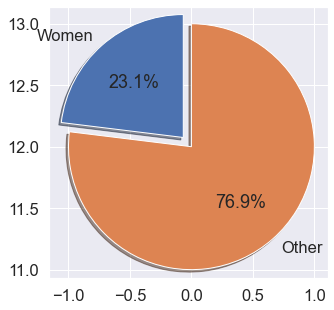

In [143]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Women', 'Other'
sizes = [627584, 2094346]
explode = (0.1, 0)  # only "explode" the 1st slice (i.e. 'Women')

fig1, ax1 = plt.subplots(figsize=(5, 5))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, center=(0, 12), frame=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

With this information we have our answer as to whether there is a gender gap in the analytical work.

What is a Gender Gap?

A quick search on google will say it is "the discrepancy in opportunities, status, attitudes, etc., between men and women." In our case we are approaching it from the angle of representation. Even though our model did not capture all the occupations that are classified as analytical in nature. We can still infer from it that 23$\%$ is not a good enough representaion of women. Therefore, we can conclude by saying that according to our model findings we have a gender gap in analytical work.

Before we get done, let us do one more thing.

With the graph below, we can see what the ratios look like in specific fields. 


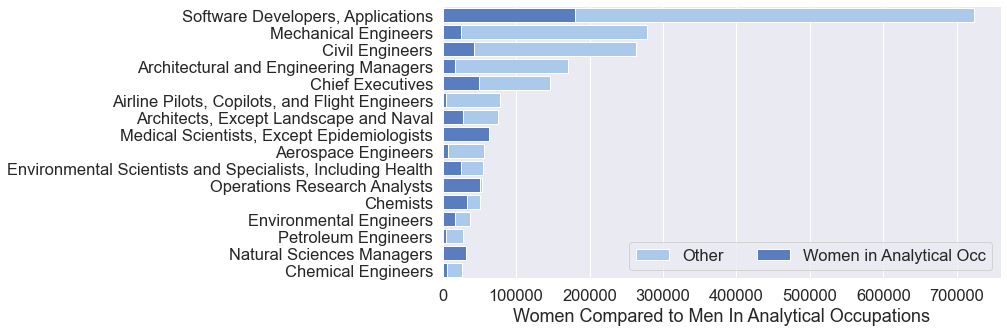

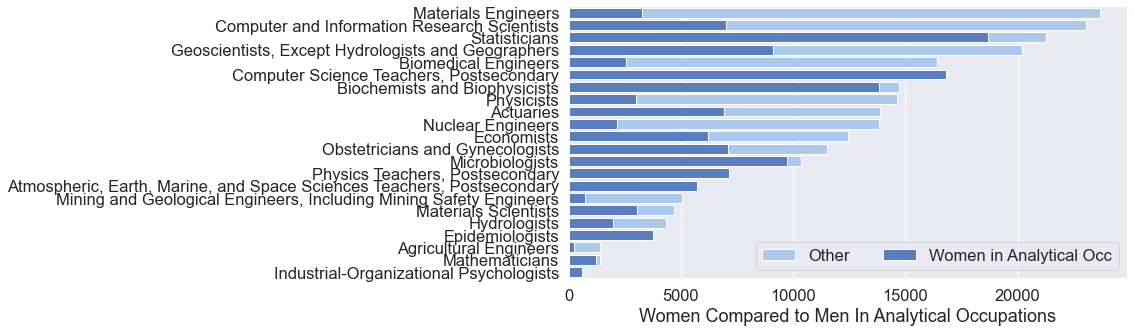

In [144]:
# For better visualization I will split the data into two
merged_occ_df = merged_occ_df.sort_values(by=['OTHERS'], ascending=False)
merged_occ_df1 = merged_occ_df.iloc[:16]
merged_occ_df2 = merged_occ_df.iloc[16:]

# plots two figures based on the data
for n in range(2):
    if n == 0:
        dataset = merged_occ_df1
    else:
        dataset = merged_occ_df2
    
    f, ax = plt.subplots(figsize=(10, 5))
    # plot the total of others
    sns.set_color_codes("pastel")
    sns.barplot(x="OTHERS", y="Title", data=dataset.sort_values("OTHERS", ascending=False),
                label="Other", color="b")

    # plot the total where women are employees
    sns.set_color_codes("muted")
    sns.barplot(x="NUM_WOMEN", y="Title", data=dataset.sort_values("OTHERS", ascending=False),
                label="Women in Analytical Occ", color="b")


    # Add a legend and informative axis label
    ax.legend(ncol=2, loc="lower right", frameon=True, )
    ax.set(ylabel="",
           xlabel="Women Compared to Men In Analytical Occupations")
    sns.despine(left=True, bottom=True)

As we can see, even though overall we have a gender gap in analytical work, when we examine specific occupations, some occupations have a higher percentage or women as compared to men. For example, `Industrial-Organizational Psychologists` has 23$\%$ more women than men. Here we would say I gender gap exists but with an underrepresentation of men. 

Alight, we will end it here.

## Thank you! We have come to the end of our Journey!!!
